In [2]:
# !pip install pandas
# !pip install micrograd
# !pip install matplotlib
# !pip install graphviz

In [3]:
import pandas
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from micrograd.engine import Value

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

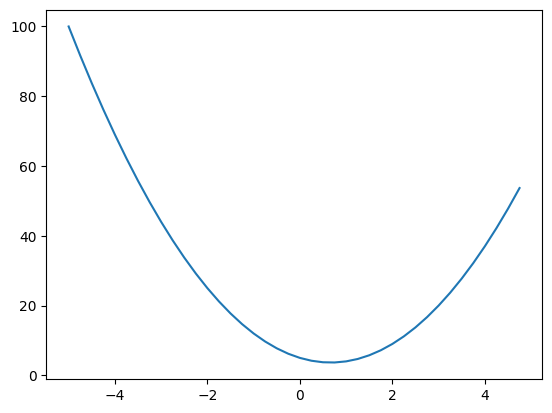

In [7]:
plt.plot(xs, ys)

In [8]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [9]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [10]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1 )/ h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [32]:
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.grad = 0.0
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __radd__(self, other): # other + self
        return self + other
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    def __rmul__(self, other):
        return self * other
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting power of int/float"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += out.grad * other * (self.data**(other - 1))
        out._backward = _backward
        return out
    def __truediv__(self, other):
        return self * other**-1
    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1)/(math.exp(2 * n) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [12]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [13]:
    from graphviz import Digraph
    def trace(root):
    # builds a set of all nodes and edges in a graph
        nodes, edges = set(), set()
        def build (v):
            if v not in nodes:
                nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
        build(root)
        return nodes, edges
    def draw_dot(root):
        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
        nodes, edges = trace(root)
        for n in nodes:
            uid = str(id(n))
            dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
            if n._op:
                # if this value is a result of some operation, create an op node for it
                dot.node(name = uid + n._op, label = n._op)
                # and connect this node to it
                dot.edge(uid + n._op, uid)
        for n1, n2 in edges:
        # connect nl to the op node of n2
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        return dot

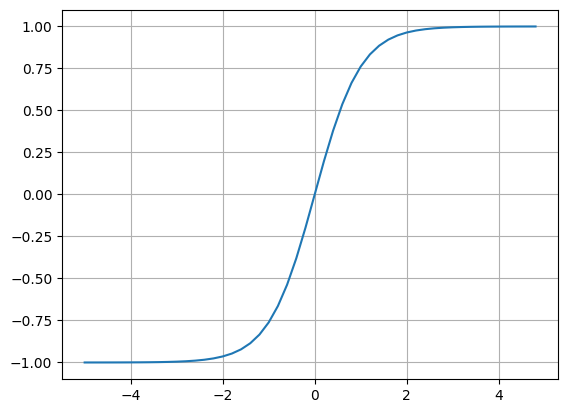

In [14]:
plt. plot(np.arange(-5,5,0.2), np. tanh(np.arange(-5,5,0.2))); plt.grid();

In [15]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#Bias
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1. label = 'x1*w1'
x2w2 = x2*w2; x2w2. label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2. label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n. label = 'n'
#--- Old Way to compute tanH
# o = n.tanh()
e = (2*n).exp()
o = (e - 1) / (e + 1)
#-------
o.label = 'o'
o.backward()
# o.grad = 1.0
# # o = tanh(n)
# # do/dn = 1 - o**2
# n.grad = 0.5
# # d(tanh(n))/dn = 1 - tanh(n)**2 = 1 - o**2
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

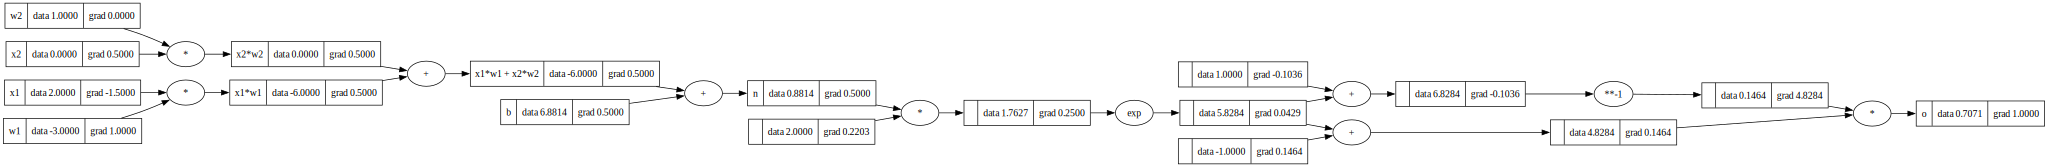

In [16]:
draw_dot(o)

In [17]:
o.backward()

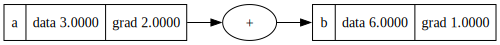

In [18]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [19]:
# Topolocial Sorting, only difference is edges go from parent to children, as we are considering child as _prev.
# so eventually when we call backward on the last variable o, we can invoke a recursive topo sort, and then the reverse order will contain the order to invoke backward, and then we can
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=1),
 Value(data=2),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=6.828427124746192),
 Value(data=0.1464466094067262),
 Value(data=-1),
 Value(data=4.828427124746192),
 Value(data=0.7071067811865477)]

In [20]:
# !pip install torch
import torch

In [21]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [22]:
torch.Tensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [186]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     params.extend(neuron.parameters())
        # return params
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        # print(sz)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        # print(i for i in range(len(nouts)))
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# n = Neuron(2)
# n = Layer(2, 3)
# n(x)

In [200]:
n = MLP(3, [4, 4, 1])
x = [2.0, 3.0, -1]
n(x)

Value(data=0.09480243241489834)

In [201]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
# ypred is not matching with ys, that means we need change our biases or weight

In [202]:
for k in range(200):
    # forward pass to evaluate loss
    ypred = [n(x) for x in xs]
    # We are finding MSE between expected and predicted, sum of these would be our total loss
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # We need to set the p.grad to zero also as we have reset the parameters, therefore the grad will change, and since we add the grads, we need to reset it to o, before we begin calc the grads for this iteration through back prop
    for p in n.parameters():
        p.grad = 0.0
    # Backward Pass
    loss.backward()
    # Update Parameters
    for p in n.parameters():
    # If grad is positive, that means increase will increase loss, if -ve then increase will decrease the loss, so we want to do the reverse of whatever our grad is
        p.data += -0.05 * p.grad
    print(k, loss.data)


0 5.96864075921113
1 4.184993059649936
2 3.1643344034365186
3 2.213219079117792
4 1.3198539633570952
5 0.7238886670420558
6 0.4284420208533608
7 0.2838774503045817
8 0.2052832580887821
9 0.15784659714820198
10 0.12679809640774262
11 0.10518469633152974
12 0.08941006746609988
13 0.07746181709741208
14 0.06813918693848849
15 0.06068704024447316
16 0.05460938516096439
17 0.049568369034136237
18 0.04532665363869644
19 0.04171305069004181
20 0.03860123240583871
21 0.035896098753170125
22 0.033524791389705
23 0.03143061749080478
24 0.029568847141015327
25 0.027903747249277813
26 0.02640644983335955
27 0.02505339465855417
28 0.023825174449202152
29 0.02270566694009509
30 0.021681374392608074
31 0.0207409152407445
32 0.019874628709308423
33 0.019074264309093456
34 0.018332735792575196
35 0.017643924557196305
36 0.017002521334856798
37 0.016403897784303668
38 0.01584400162927172
39 0.015319270478373746
40 0.014826560573829804
41 0.014363087550495573
42 0.01392637691860669
43 0.01351422246619527

In [203]:
ypred

[Value(data=0.9828190152456358),
 Value(data=-0.9829150794013861),
 Value(data=-0.9729513252344552),
 Value(data=0.9700162666413491)]